# Определение стоимости автомобилей

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

### В рамках данного проекта нам предстоит:
- проанализировать и обработать исторические данные по объявлениям продажи автомобилей
- обучить несколько моделей и подобрать гиперпараметры
- обучить итоговые модели с подобранными параметрами и сравнить результаты по качеству предсказания и временным показателям

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import warnings

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Перед нами большой пул исторических данных с объявлениями по продаже автомобилей

Удалим столбцы с ненужной информацией:

In [5]:
df = data.drop(['DateCrawled','PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)

In [6]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00


Пропуски в данных:

In [7]:
df.isnull().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
dtype: int64

#### Взглянем на разброс данных с точки зрения возможных выбросов:

In [8]:
numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

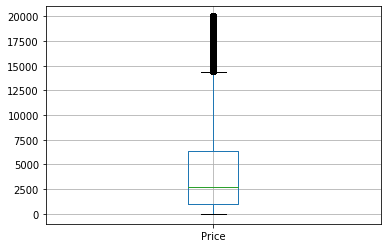

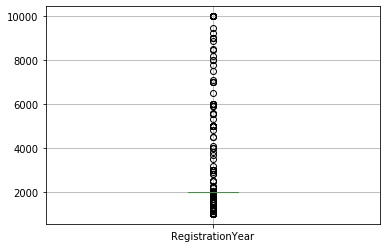

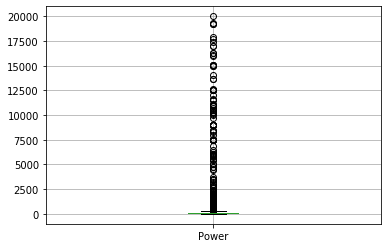

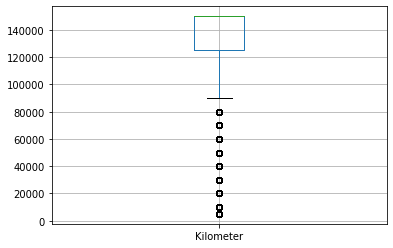

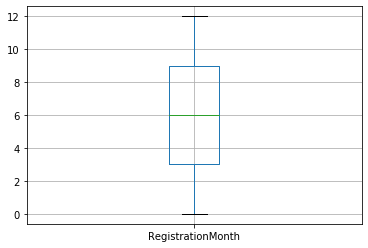

In [9]:
for i in numeric:
    df.boxplot(i)
    plt.show()

Наблюдения:
- год регистрации - боксплот "схлопнулся", хотя на гистограмме все значения на пике 2000
- мощность - аналогично, много данных с "0" и с выбросами 
- пробег - на первый взгляд все нормально
- цена - много "0", есть хвост после 14к евро

### Год регистрации
Взглянем, какие данные есть в столбце:

In [9]:
pd.Series(df['RegistrationYear'].unique()).sort_values()

70     1000
118    1001
133    1039
39     1111
102    1200
       ... 
91     9000
143    9229
119    9450
134    9996
67     9999
Length: 151, dtype: int64

Большое количество выбросов

**Возьмем в дальнейшую работы авто с годом регистрации в диапазоне 1920-2016:**

In [10]:
df1 = df.query('1920 < RegistrationYear <= 2016').copy()

#### Рассчитаем "вораст" автомобилей в месяцах:

In [11]:
df1['year'] = pd.DatetimeIndex(df1['DateCreated']).year # определим год размещения объявления
df1['month'] = pd.DatetimeIndex(df1['DateCreated']).month # и месяц
df1['car_age'] = (df1['year'] - df1['RegistrationYear'])*12 # посчитаем, сколько автомобилю месяцев
df1 = df1.drop(['RegistrationMonth', 'DateCreated', 'year', 'month'], axis=1) # лишнее можно удалить (год авто пока оставим)

In [12]:
df1.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,car_age
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,276
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,60
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,144


### Мощность

В первую очередь необходимо решить проблему с большим количеством нулей в этом признаке.

**Сделаем сводную таблицу с мощностями моделей каждого бренда авто по годам:**

In [13]:
power_pivot = df1.pivot_table(index=['Brand', 'Model', 'RegistrationYear'], values='Power', aggfunc='mean')

**Заменим нули в мощностях на соответвующие средние значения из сводной таблицы:**

In [14]:
def fill_power(row, pivot):
    if row['Power'] == 0:
        tuple_index = tuple([row['Brand'], row['Model'], row['RegistrationYear']])
        if tuple_index in pivot.index:
            new_value = pivot.loc[tuple_index]['Power']
            return int(new_value)
    
    else:
        old_value = row['Power']
        return int(old_value)

In [15]:
df1['Power'] = df1.apply(fill_power, axis=1, args=[power_pivot])

Проанализируем данные, в которых заполнить нули не удалось:

In [16]:
df1[df1['Power'].isnull()].isnull().sum()

Price                  0
VehicleType         2901
RegistrationYear       0
Gearbox             2815
Power               5505
Model               5505
Kilometer              0
FuelType            3039
Brand                  0
NotRepaired         3828
car_age                0
dtype: int64

Полностью отсутствуют данные о названии модели, большое количество пропусков в типе кузова, коробке передач и т.д.

В связи с чем, **эти объекты лучше удалить, а не восстанавливать**

**Для дальнейшей работы сделаем срез от 40 до 800 л.с.** (верхний порог подобрал по авто.ру, хотя формула Q3+1.5*IQR давала 251 лс) 

In [17]:
df2 = df1.query('40 < Power < 800')

### Цена
Имеем немалое количество машин с очень низкими ценами и с нулями. Хоть боксплот нижним "усом" и упирается в 0, отсечение цен по нижней планке мы все-таки сделаем

Взглянем на распределение цен в интервале 0-1000 евро:

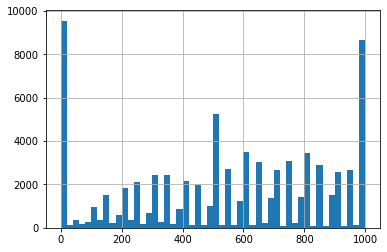

In [18]:
df2['Price'].hist(bins=50, range=(0,1000))
plt.show()

Сложно представить автомобиль дешевле 200 евро (если, конечно, он не "убит"), **сделаем отсечку по 200 евро** (можно было и больше, но не хочется терять большое количество данных)

Что насчет верхней отсечки? Общий боксплот указывает на выбросы свыше 16000 евро, а формула Q1-1.5*IQR дает значение 15400:

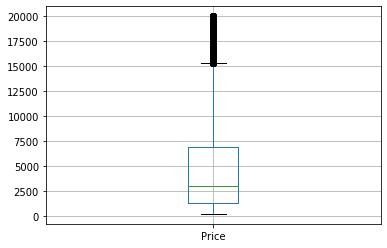

In [19]:
df2.query('Price > 200').boxplot('Price')
plt.show()

**Не совсем правильно делать выводы по всем автомобилям сразу. Так как есть более дорогой и менее выпускаемый класс авто, который и может на общей картине превращаться в "выбросы"**

Выделим топ 10 дорогих брендов и построем боксплот для них:

In [20]:
top10 = df2.pivot_table(index='Brand', values='Price').sort_values('Price', ascending=False).head(10)
top10

,Price
Brand,
porsche,11638.934593
mini,9150.337251
land_rover,8590.899807
sonstige_autos,7598.667464
jeep,7217.918495
jaguar,6820.575569
audi,6356.040493
bmw,6276.908293
mercedes_benz,6000.206663


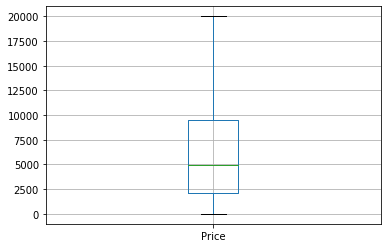

In [21]:
df2.query('Brand in @top10.index').boxplot('Price')
plt.show()

**Вот тут уже выбросов нет.**

Кроме того, стоимость 20 000 сама по себе не похожа на выброс, поэтому **отсекать данные по верхнему значению мы не будем**

Взглянем на измнение **средней стоимости автомобилей по годам в связке с количеством их выпуска (регистраций):**

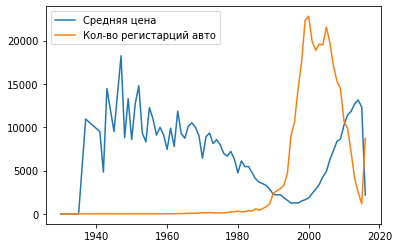

In [22]:
plt.plot(df2.pivot_table(index='RegistrationYear', values='Price'), label='Средняя цена')
plt.plot(df2.pivot_table(index='RegistrationYear', values='Price', aggfunc='count'), label='Кол-во регистарций авто')
plt.legend()
plt.show()

Интересная карнтина средней цены (особенно в отрыве от количества загружаемых объявлений), вероятно, что эти дорогие автомобили являются раритетными

**Выделим автомобили стоимостью больше 200 евро**

In [23]:
df3 = df2.query('Price > 200')

### Тип кузова/коробки передач/топлива

Эти признаки являются категориальными, заполним пропуски в них на самые популярные для соответсвующих моделей по годам

In [24]:
def pivot_tab(columns):
    return df3.pivot_table(index=['Brand', 'Model', 'RegistrationYear'], columns=columns, aggfunc='size')
 
def fill_value(row, series, pivot): 
    if row[series] == 'unknown':
        tuple_index = tuple([row['Brand'], row['Model'], row['RegistrationYear']])
        if tuple_index in pivot.index:
            return pivot.loc[tuple_index].idxmax()
    else:
        return row[series]

In [25]:
pivot_VehicleType = pivot_tab('VehicleType') # делаем сводные таблицы
pivot_Gearbox = pivot_tab('Gearbox')
pivot_FuelType = pivot_tab('FuelType')

In [26]:
warnings.filterwarnings("ignore")
df3['VehicleType'] = df3['VehicleType'].fillna('unknown') # заменяем пропуски на 'unknown' для работы с ними
df3['Gearbox'] = df3['Gearbox'].fillna('unknown')
df3['FuelType'] = df3['FuelType'].fillna('unknown')

In [27]:
df3['VehicleType'] = df3.apply(fill_value, axis=1, args=['VehicleType', pivot_VehicleType])
df3['Gearbox'] = df3.apply(fill_value, axis=1, args=['Gearbox', pivot_Gearbox])
df3['FuelType'] = df3.apply(fill_value, axis=1, args=['FuelType', pivot_FuelType])

Посмотрим, сколько пропусков удалось заполнить:

In [28]:
df3.isnull().sum()

Price                   0
VehicleType          4510
RegistrationYear        0
Gearbox               640
Power                   0
Model               10437
Kilometer               0
FuelType             2548
Brand                   0
NotRepaired         51992
car_age                 0
dtype: int64

**Не идеально, но уже лучше**

### Модель и ремонт
Пропуски в наименовании моделей авто и в ремонте заменим на 'unknown'

In [29]:
df3['Model'] = df3['Model'].fillna('unknown')
df3['NotRepaired'] = df3['NotRepaired'].fillna('unknown')

df3 = df3.dropna() # удалим оставшивеся пропуски
df3['Power'] = df3['Power'].astype('int')
df3 = df3.drop('RegistrationYear', axis=1)

### Корреляция признаков

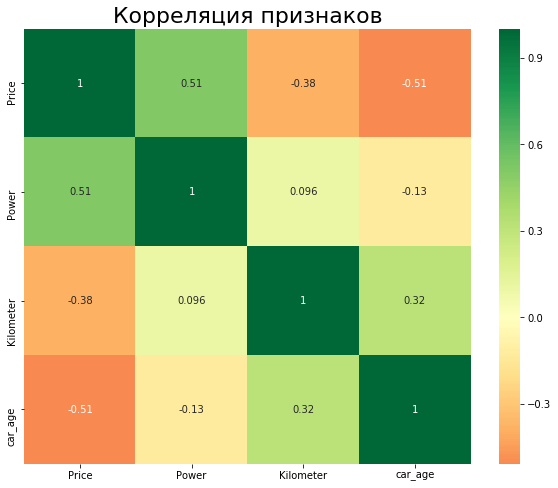

In [30]:
plt.figure(figsize=(10,8))
sns.heatmap(df3.corr(), cmap='RdYlGn', center=0, annot=True)
plt.title('Корреляция признаков', fontsize=22)
plt.show()

Максимальная корреляция 0,51(-0,51) цены с мощностью и возрастом авто.

**Приемлемые и логичные показатели**, идем дальше

### Кодирование категоральных признаков
Для последующих работ сделаем три датасета:
- исходный (без кодировки)
- с кодировкой ОЕ
- с кодировкой OHE


In [31]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# OE
df3_OE = df3.copy()
encoder = OrdinalEncoder()
encoder.fit(df3[cat_columns])
df3_OE[cat_columns] = encoder.transform(df3[cat_columns])

# OHE
df3_OHE = pd.get_dummies(df3, drop_first=True)

### Разделим данные на выборки

In [32]:
# Original
target_orig = df3['Price']
features_orig = df3.drop(['Price'], axis=1)

features_train_orig, features_valid_orig, target_train_orig, target_valid_orig = train_test_split(
    features_orig, target_orig, test_size=0.25, random_state=123455)

In [33]:
# OE
target_OE = df3_OE['Price']
features_OE = df3_OE.drop(['Price'], axis=1)

features_train_OE, features_valid_OE, target_train_OE, target_valid_OE = train_test_split(
    features_OE, target_OE, test_size=0.25, random_state=123455)

In [34]:
# OHE
target_OHE = df3_OHE['Price']
features_OHE = df3_OHE.drop(['Price'], axis=1)

features_train_OHE, features_valid_OHE, target_train_OHE, target_valid_OHE = train_test_split(
    features_OHE, target_OHE, test_size=0.25, random_state=123455)

In [35]:
features_train_orig.head(1)

,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,car_age
353380,sedan,manual,150,3er,150000,petrol,bmw,no,276


### Масштабирование

In [36]:
numeric = ['Power', 'Kilometer', 'car_age']
numeric_OE = ['VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'car_age']

def scaler_df(numeric, features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    return features_train, features_valid

features_train_orig, features_valid_orig = scaler_df(numeric, features_train_orig, features_valid_orig)
features_train_OE, features_valid_OE = scaler_df(numeric_OE, features_train_OE, features_valid_OE)
features_train_OHE, features_valid_OHE = scaler_df(numeric, features_train_OHE, features_valid_OHE)

# 2. Обучение моделей

Введем функции расчета RMSE и процесса обучения/предсказаний моделей:

In [37]:
def rmse(target_valid, predicted):
    return (mean_squared_error(target_valid, predicted)**0.5).round(2)

def rmse_gridsearch(score_best):
    return (((score_best)*(-1))**0.5).round(2)

def fit_predict(model, features_cat, features_train, target_train, features_valid):
    if features_cat != None:
        model.fit(features_train, target_train, cat_features=features_cat, verbose=10)
        predicted = model.predict(features_valid)
    else:
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
    return predicted

### Для начала:
- создадим модели
- обучим их с дефолтными параметрами на датасетах:
    - без кодировки категориальных данных
    - с кодировкой ОНЕ
    - с кодировкой ОЕ
- сделаем предсказания и оценим RMSE

In [38]:
model_Cat = CatBoostRegressor(random_state=12345)
model_LG = lgb.LGBMRegressor(random_state=12345)
model_XGB = xgb.XGBRegressor(random_state=12345)
model_RF = RandomForestRegressor(random_state=12345)
model_LR = LinearRegression()

In [39]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [ ]:
# CatBoost
predicted_cat_orig = fit_predict(model_Cat, cat_features, features_train_orig, target_train_orig, features_valid_orig)
predicted_cat_OHE = fit_predict(model_Cat, None, features_train_OHE, target_train_OHE, features_valid_OHE)
predicted_cat_OE = fit_predict(model_Cat, None, features_train_OE, target_train_OE, features_valid_OE)

In [41]:
# LGBM
predicted_LG_OHE = fit_predict(model_LG, None, features_train_OHE, target_train_OHE, features_valid_OHE)
predicted_LG_OE = fit_predict(model_LG, None, features_train_OE, target_train_OE, features_valid_OE)

# RANDOM FOREST
predicted_RF_OHE = fit_predict(model_RF, None, features_train_OHE, target_train_OHE, features_valid_OHE)
predicted_RF_OE = fit_predict(model_RF, None, features_train_OE, target_train_OE, features_valid_OE)

# LR
predicted_LR_OHE = fit_predict(model_LR, None, features_train_OHE, target_train_OHE, features_valid_OHE)
predicted_LR_OE = fit_predict(model_LR, None, features_train_OE, target_train_OE, features_valid_OE)

Результаты:

In [42]:
print('Cat_Orig', rmse(target_valid_orig, predicted_cat_orig))
print('Cat_OHE ', rmse(target_valid_OHE, predicted_cat_OHE))
print('Cat_OE  ', rmse(target_valid_OE, predicted_cat_OE))
print()
print('LG_OHE ', rmse(target_valid_OHE, predicted_LG_OHE))
print('LG_OE  ', rmse(target_valid_OE, predicted_LG_OE))
print()
print('RF_OHE ', rmse(target_valid_OHE, predicted_RF_OHE))
print('RF_OE  ', rmse(target_valid_OE, predicted_RF_OE))
print()
print('LR_OHE ', rmse(target_valid_OHE, predicted_LR_OHE))
print('LR_OE  ', rmse(target_valid_OE, predicted_LR_OE))

Cat_Orig 1627.98
Cat_OHE  1654.67
Cat_OE   1657.33

LG_OHE  1649.65
LG_OE   1664.73

RF_OHE  1581.01
RF_OE   1604.4

LR_OHE  674915841748.18
LR_OE   2887.92


- **лучшие результаты с дефолтными параметрами показали CatBoost и RandomForest, далее LGBM и XGB_OHE**
- сильно уступает LinearRegression, показав на данных с кодировкой ОНЕ очень странный результат

### Подбор гиперпараметров

In [43]:
def run_gridsearch(model, params, X, Y):
    grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    grid.fit(X, Y)

    print(grid.best_params_)
    print(rmse_gridsearch(grid.best_score_))

In [44]:
parametrs_Cat = {'depth': [4,7,10],
                 'learning_rate': [0.03, 0.1, 0.15],
                 'iterations': [100, 200, 300]
              }

parametrs_LG = {'max_depth': [20,50,75],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'num_leaves': [300, 900, 1200],
                 'n_estimators': [200]
              }

parametrs_RF = { 'n_estimators': [30, 70, 100],
              'max_depth': [3,8,15]}

#### Подбор гиперпараметров для CatBoost:

In [ ]:
# orig
run_gridsearch(model_Cat, parametrs_Cat, features_train_orig, target_train_orig)

1573.48, при 'depth': 10, 'iterations': 300, 'learning_rate': 0.15

In [ ]:
# OHE
run_gridsearch(model_Cat, parametrs_Cat, features_train_OHE, target_train_OHE)

1578.12, при 'depth': 10, 'iterations': 300, 'learning_rate': 0.15

In [ ]:
# OE
run_gridsearch(model_Cat, parametrs_Cat, features_train_OE, target_train_OE)

1591,79, при 'depth': 10, 'iterations': 300, 'learning_rate': 0.15

#### Подбор гиперпараметров для LGBM:

In [ ]:
# OHE
run_gridsearch(model_LG, parametrs_LG, features_train_OHE, target_train_OHE)

1535.52, при 'learning_rate': 0.1, 'max_depth': 75, 'n_estimators': 200, 'num_leaves': 300

In [ ]:
# OE
run_gridsearch(model_LG, parametrs_LG, features_train_OE, target_train_OE)

1561.14, при 'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 200, 'num_leaves': 300

#### Подбор гиперпараметров для Random Forest:

In [ ]:
# OHE
grid = GridSearchCV(model_RF, parametrs_RF, scoring='neg_mean_squared_error', cv=3)
grid.fit(features_train_OHE, target_train_OHE)
print(grid.best_params_)
rmse_gridsearch(grid.best_score_)

- {'max_depth': 15, 'n_estimators': 100}
- 1686.8781750773355

### Выводы:

Из проработаных моеделей можно выделить:
- **CatBoost с RMSE=1573.48** с кодировкой ОНЕ,  при 'depth': 10, 'iterations': 300, 'learning_rate': 0.15
- **LGBM с RMSE=1535,52** с кодировкой OHE, при 'learning_rate': 0.1, 'max_depth': 75, 'n_estimators': 200, 'num_leaves': 300
- **LGBM с RMSE=1561,14** с кодировкой OE, при тех же параметрах

# 3. Анализ моделей
Сравним модели с подобранными параметрами по показателям:
- качества предсказания
- время обучения
- время предсказания

In [ ]:
model_Cat_final = CatBoostRegressor(depth=10, learning_rate=0.15, iterations=300, random_state=12345)
model_LG_final = lgb.LGBMRegressor(learning_rate=0.1, max_depth=75, n_estimators=200, num_leaves=300, random_state=12345)

In [46]:
def count_time(model_, X, Y, X_valid, Y_valid):
    start_time = time.perf_counter()
    model = model_
    model.fit(X, Y)
    time_1 = float('{0:.2f}'.format(time.perf_counter() - start_time))
    
    start_time = time.perf_counter()
    predict = model.predict(X_valid)
    RMSE = rmse(Y_valid, predict)
    time_2 = float('{0:.2f}'.format(time.perf_counter() - start_time))
    print(RMSE)
    print(time_1)
    print(time_2)
    return RMSE, time_1, time_2

#### CatBoost

In [ ]:
RMSECat, timeCat1, timeCat2 = count_time(model_Cat_final, features_train_OHE, target_train_OHE, 
                                         features_valid_OHE, target_valid_OHE)

In [58]:
print(RMSECat)
print(timeCat1)
print(timeCat2)

1551.0
90.7
0.31


#### LGBM на данных с кодировками ОНЕ и ОЕ:

In [ ]:
RMSE_LG_OHE, time1_LG_OHE, time2_LG_OHE = count_time(model_LG_final, features_train_OHE, target_train_OHE, 
                                           features_valid_OHE, target_valid_OHE)

- 1496.19
- 48.27
- 5.25

In [ ]:
RMSE_LG_OE, time1_LG_OE, time2_LG_OE = count_time(model_LG_final, features_train_OE, target_train_OE, 
                                           features_valid_OE, target_valid_OE)

- 1499.99
- 34.40
- 3.90

In [ ]:
data_model = [['CatBoost', RMSECat,  timeCat1, timeCat2, timeCat1+timeCat2],
                 ['LGBM_OHE', RMSE_LG_OHE,  time1_LG_OHE, time2_LG_OHE, time1_LG_OHE+time2_LG_OHE],
                 ['LGBM_OE', RMSE_LG_OE,  time1_LG_OE, time2_LG_OE, time1_LG_OE+time2_LG_OE]
                ]
results = pd.DataFrame(data_model, columns = ['Model', 'RMSE','Time_fit','Time_predict', 'Time_total'])

results

### Выводы

- мы проанализировали и обработали данные
- обучили несколько моделей на данных с разными способами обработки категориальных признаков и подобрали гиперпараметры
- обучили итоговые модели с подобранными параметрами и сравнили результаты по качеству предсказания и временным показателям, результаты:


In [56]:
results

,Model,RMSE,Time_fit,Time_predict,Time_total
0,CatBoost,1551.00,91.99,0.39,92.38
1,LGBM_OHE,1496.19,48.27,5.25,53.52
2,LGBM_OE,1499.99,34.40,3.90,38.30


**Модели LightGBM показали лучшие результаты с точки зрения качества предсказаний и времени обучения:**
- для LightGBM на данных с кодировкой ОЕ **RMSE=1499.99, Time_fit=34.4 с, Time_predict=3.9 с**

**С точки зрения времени предсказания лучший результат у CatBoost Time_predict=0,39**, при этом Time_fit=91,99, а RMSE=1551